<a href="https://colab.research.google.com/github/marloarm/CE4510_Speed_Profiles/blob/main/ce_4510_MP2_speed_profiles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CE 4510 Mini Project #2 Description & Instructions

**CE 4510 Mini Project #2
Marlo Armstrong**

*Speed Profile Analysis — North Nashville (Clarksville Pike Corridor)*

This project analyzes vehicle speed behavior across a monitored urban corridor in North Nashville using trajectory data from NDOT’s LADDMS system. The goal is to identify speeding hotspots, acceleration patterns, and overall traffic flow characteristics along segments of Clarksville Pike and surrounding areas.

To run this code, download the data from NDOT LADDMS linked here: https://vanderbilt.app.box.com/s/7pzzb1i76m048nbtlkil9y1tq6psnpiv and upload it to the files section on Google Colab Jupyter Notebook. Then you may proceed to run the necessary code.


**Purpose**

To visualize and quantify where, when, and how vehicles accelerate or slow down along the corridor, helping inform decisions about traffic calming, roadway design improvements, or enforcement targeting.


**What the Code Does**

Loads and preprocesses JSON trajectory data (UTM coordinates, velocities, timestamps).

Computes average vehicle speeds in both m/s and mph, then bins results by distance (50 m) and time (1 min).

Generates multiple visualizations including:

- A speed heatmap (distance vs. time) showing stop-and-go dynamics.

- A folium interactive map with colored markers and a heat overlay of speeding zones.

- A longitudinal speed profile identifying acceleration and deceleration trends.

- A temporal hotspot analysis connecting speed peaks to specific time intervals.

- Identifies the top 3 speeding zones, converts UTM to latitude/longitude, and labels them geographically (e.g., West Nashville / Charlotte Ave area).


**Outcome**

The code provides an integrated view of traffic speed variability along the corridor—highlighting where vehicles accelerate most after intersection stops, where speeds peak (up to ~48 mph), and when congestion dominates. This workflow can be replicated for other NDOT corridors to support data-driven traffic engineering and safety studies.

# Data Loading and Speed Computation

This section imports and preprocesses the raw trajectory JSON dataset.
It loads NDOT’s LADDMS data, flattens nested JSON fields into a Pandas DataFrame, and computes each vehicle’s instantaneous speed (m/s) using the x- and y-velocity components.
The output provides the foundational dataset used for all subsequent spatial and temporal speed analyses.


In [2]:
import pandas as pd
import numpy as np
import json

# ---------------------------
# Load JSON data properly
# ---------------------------
traj_file = "sample_data.json"

with open(traj_file, "r") as f:
    data = json.load(f)

# If the JSON has a top-level key (like {"trajectories": [...]})
if isinstance(data, dict):
    if "trajectories" in data:
        data = data["trajectories"]
    elif "data" in data:
        data = data["data"]

# Flatten nested fields into columns
df = pd.json_normalize(data)

print("Loaded rows:", len(df))
print("Columns:", df.columns.tolist())
print(df.head())

# ---------------------------
# Compute speed
# ---------------------------
# Extract the first element from the lists in 'vel_x' and 'vel_y' columns
# This assumes each list contains at least one element and the first element is the relevant value
if {"vel_x", "vel_y"}.issubset(df.columns):
    df["speed_mps"] = np.sqrt(df["vel_x"].apply(lambda x: x[0])**2 + df["vel_y"].apply(lambda x: x[0])**2)
elif {"vx", "vy"}.issubset(df.columns):
    df["speed_mps"] = np.sqrt(df["vx"].apply(lambda x: x[0])**2 + df["vy"].apply(lambda x: x[0])**2)
elif {"velocity.vx", "velocity.vy"}.issubset(df.columns):
    df["speed_mps"] = np.sqrt(df["velocity.vx"].apply(lambda x: x[0])**2 + df["velocity.vy"].apply(lambda x: x[0])**2)
elif "speed" in df.columns:
    df["speed_mps"] = df["speed"].apply(lambda x: x[0])
else:
    raise KeyError("No velocity fields found — check df.columns above to see available names")


print(df[["speed_mps"]].head())

Loaded rows: 11636
Columns: ['object_id', 'location_id', 'classification', 'sub_classification', 'obj_length', 'obj_width', 'obj_height', 'avg_filtered_confidence', 'ts', 'vel_x', 'vel_y', 'utm_x', 'utm_y']
   object_id  location_id classification sub_classification  obj_length  \
0    3349568            7        VEHICLE              truck    8.909214   
1    3349767            7        VEHICLE                car    4.511636   
2    3349772            7         PERSON         pedestrian    0.611551   
3    3349774            7        VEHICLE                car    4.549750   
4    3349777            7        VEHICLE                car    4.813739   

   obj_width  obj_height  avg_filtered_confidence  \
0   2.781003    3.257654                 0.621689   
1   1.946927    1.554887                 0.957362   
2   0.609588    1.694812                 0.756013   
3   1.999649    1.576131                 0.916461   
4   2.082503    1.748981                 0.833412   

                       

# Time-Binned Speed Analysis and Preliminary Visualization

This section performs temporal and spatial speed analysis by grouping vehicle data into 30-second time intervals and examining how average speed evolves across the monitored roadway.
The code:

- Loads and normalizes JSON trajectory data into a clean DataFrame.
- Computes instantaneous speed (m/s) and approximate travel distance from UTM coordinates.
- Segments the dataset into 30-second time bins to capture short-term speed variations.
- Produces two key plots:
  - Distance vs. Speed scatterplots showing vehicle distribution by time window.
  - Average Speed Over Time, revealing overall acceleration and deceleration trends.
- Identifies high-speed (top 20%) and low-speed (bottom 20%) zones to highlight potential speeding or congestion intervals for further analysis.

Data loaded: 11636 rows
['object_id', 'location_id', 'classification', 'sub_classification', 'obj_length', 'obj_width', 'obj_height', 'avg_filtered_confidence', 'ts', 'vel_x']


/tmp/ipython-input-1939196979.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_speed_by_bin = df.groupby("time_bin")["speed"].mean().reset_index()
/tmp/ipython-input-1939196979.py:55: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for interval, group in df.groupby("time_bin"):
/tmp/ipython-input-1939196979.py:63: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


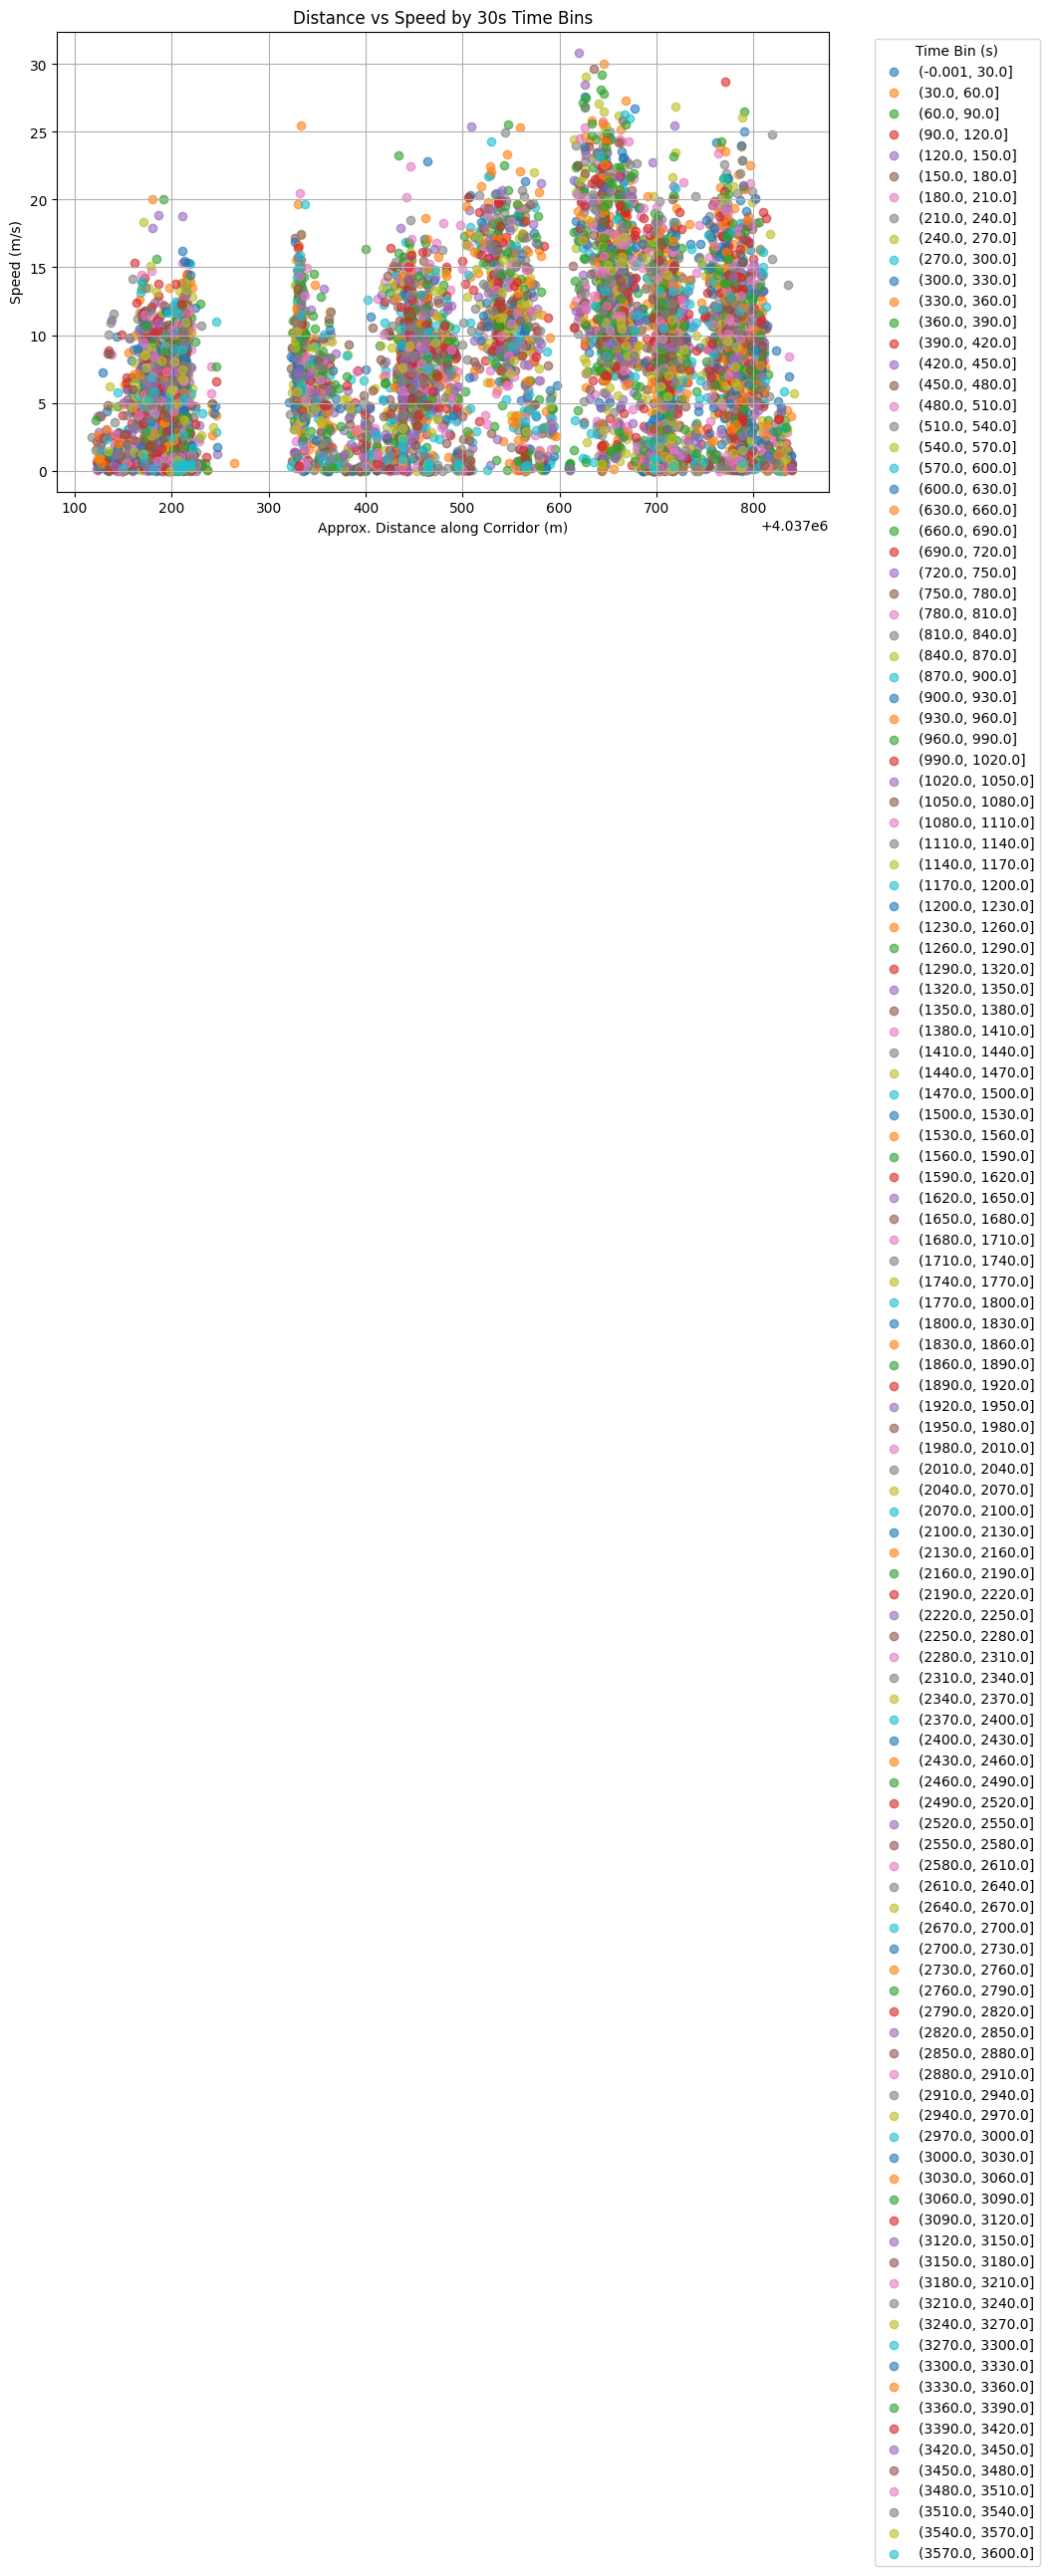

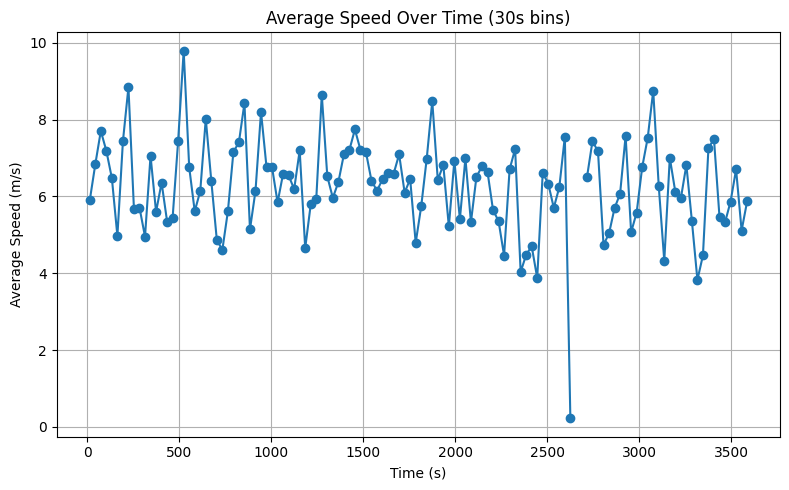


--- High Speed Hotspots (Bins w/ most speeding) ---
time_bin
(-0.001, 30.0]      38
(30.0, 60.0]        22
(60.0, 90.0]        25
(90.0, 120.0]       25
(120.0, 150.0]      16
                    ..
(3450.0, 3480.0]    21
(3480.0, 3510.0]    22
(3510.0, 3540.0]    23
(3540.0, 3570.0]    11
(3570.0, 3600.0]    18
Name: count, Length: 120, dtype: int64

--- Low Speed / Congestion Zones ---
time_bin
(-0.001, 30.0]      58
(30.0, 60.0]        15
(60.0, 90.0]        10
(90.0, 120.0]       13
(120.0, 150.0]      17
                    ..
(3450.0, 3480.0]    29
(3480.0, 3510.0]    22
(3510.0, 3540.0]    20
(3540.0, 3570.0]    26
(3570.0, 3600.0]    16
Name: count, Length: 120, dtype: int64


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

# ---------------------------------------------------------------------------
# Load JSON Data
# ---------------------------------------------------------------------------

file_path = "sample_data.json"
with open(file_path, "r") as f:
    data = json.load(f)

# Some versions nest the data under keys like 'trajectories' or 'data'
if isinstance(data, dict):
    if "trajectories" in data:
        data = data["trajectories"]
    elif "data" in data:
        data = data["data"]

# Flatten to DataFrame
df = pd.json_normalize(data)
print("Data loaded:", len(df), "rows")
print(df.columns.tolist()[:10])  # preview

# ---------------------------------------------------------------------------
# Process Speed and Distance
# ---------------------------------------------------------------------------
# Combine velocity components into speed magnitude (m/s)
df["speed"] = np.sqrt(df["vel_x"].apply(lambda x: x[0] if isinstance(x, list) else x)**2 +
                      df["vel_y"].apply(lambda y: y[0] if isinstance(y, list) else y)**2)

# Compute average UTM position per object (to approximate distance along corridor)
df["utm_x_mean"] = df["utm_x"].apply(lambda x: np.mean(x) if isinstance(x, list) else x)
df["utm_y_mean"] = df["utm_y"].apply(lambda y: np.mean(y) if isinstance(y, list) else y)
df["distance"] = np.sqrt(df["utm_x_mean"]**2 + df["utm_y_mean"]**2)

# ---------------------------------------------------------------------------
# Bin Data by Time (e.g., 0-30 s, 30-60 s, etc.)
# ---------------------------------------------------------------------------
# Access the maximum value within each list in the 'ts' column
max_ts = df["ts"].apply(lambda x: max(x) if isinstance(x, list) else x).max()
time_bins = np.arange(0, max_ts + 30, 30)
df["time_bin"] = pd.cut(df["ts"].apply(lambda x: x[0] if isinstance(x, list) else x), bins=time_bins, include_lowest=True)


# Compute average speed per bin
avg_speed_by_bin = df.groupby("time_bin")["speed"].mean().reset_index()
avg_speed_by_bin["time_bin_mid"] = avg_speed_by_bin["time_bin"].apply(lambda x: x.mid)

# ---------------------------------------------------------------------------
# Visualization: Distance vs Speed by Time Bin
# ---------------------------------------------------------------------------
plt.figure(figsize=(10, 6))
for interval, group in df.groupby("time_bin"):
    plt.scatter(group["distance"], group["speed"], label=str(interval), alpha=0.6)

plt.title("Distance vs Speed by 30s Time Bins")
plt.xlabel("Approx. Distance along Corridor (m)")
plt.ylabel("Speed (m/s)")
plt.legend(title="Time Bin (s)", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------------
# Visualization: Average Speed Over Time
# ---------------------------------------------------------------------------
plt.figure(figsize=(8, 5))
plt.plot(avg_speed_by_bin["time_bin_mid"], avg_speed_by_bin["speed"], marker='o')
plt.title("Average Speed Over Time (30s bins)")
plt.xlabel("Time (s)")
plt.ylabel("Average Speed (m/s)")
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------------
# Identify Speed Hotspots and Low-Speed Zones
# ---------------------------------------------------------------------------
threshold_high = df["speed"].quantile(0.8)
threshold_low = df["speed"].quantile(0.2)

high_speed_bins = df[df["speed"] > threshold_high]["time_bin"].value_counts().sort_index()
low_speed_bins = df[df["speed"] < threshold_low]["time_bin"].value_counts().sort_index()

print("\n--- High Speed Hotspots (Bins w/ most speeding) ---")
print(high_speed_bins)

print("\n--- Low Speed / Congestion Zones ---")
print(low_speed_bins)

# Speed Heatmap and Segment-Level Hotspot Analysis

This section visualizes spatial and temporal speed variation along the monitored roadway using a heatmap and segment statistics. It reveals how vehicle speeds change both over time and across distance, helping identify where speeding or congestion commonly occurs.

The code:

- Loads and flattens LADDMS JSON trajectory data into a DataFrame.
- Calculates instantaneous speed (m/s → mph) and approximates distance traveled using average UTM coordinates.
- Bins data into 1-minute time intervals and 50-meter distance segments, then computes mean speeds for each bin.
- Generates a Speed Profile Heatmap showing how vehicle speeds fluctuate throughout the corridor (red = faster, green = slower).
- Identifies the single highest-speed bin and its approximate time and location.
- Summarizes segment-level statistics (mean, standard deviation, and maximum speeds) across 100 m bins to pinpoint:
  - Top 5 speeding segments (potential safety risks).
  - Bottom 5 low-speed zones (possible congestion or intersection delay).

This stage transitions the analysis from raw velocity data to an interpretable visual traffic behavior map, setting the foundation for the later geographic and temporal hotspot exploration.

Data loaded: 11636 rows
Columns: ['object_id', 'location_id', 'classification', 'sub_classification', 'obj_length', 'obj_width', 'obj_height', 'avg_filtered_confidence', 'ts', 'vel_x'] ...



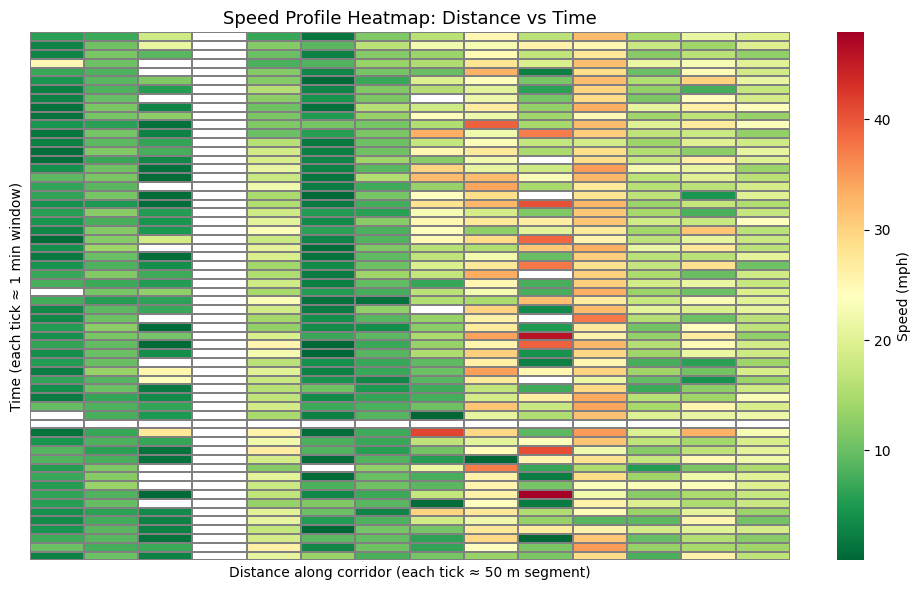

Highest average speed: 47.9 mph
Approx. location: 4037593 m along corridor
Approx. time: 3150 s (~52.5 min)

--- Top 5 Speeding Segments (Highest Avg Speeds) ---
               distance_bin  avg_speed_mph  max_speed_mph
4  (4037517.63, 4037617.63]      23.170859      57.164162
5  (4037617.63, 4037717.63]      20.541348      69.040831
6  (4037717.63, 4037817.63]      18.183546      64.197922
2  (4037317.63, 4037417.63]      12.691303      57.012726
3  (4037417.63, 4037517.63]      10.205979      56.760546

--- Bottom 5 Segments (Likely Congestion Areas) ---
               distance_bin  avg_speed_mph  max_speed_mph
6  (4037717.63, 4037817.63]      18.183546      64.197922
2  (4037317.63, 4037417.63]      12.691303      57.012726
3  (4037417.63, 4037517.63]      10.205979      56.760546
0  (4037117.63, 4037217.63]       8.824027      44.850874
1  (4037217.63, 4037317.63]       5.326706      34.081902


/tmp/ipython-input-3131401960.py:106: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_summary = df.groupby("distance_bin").agg(


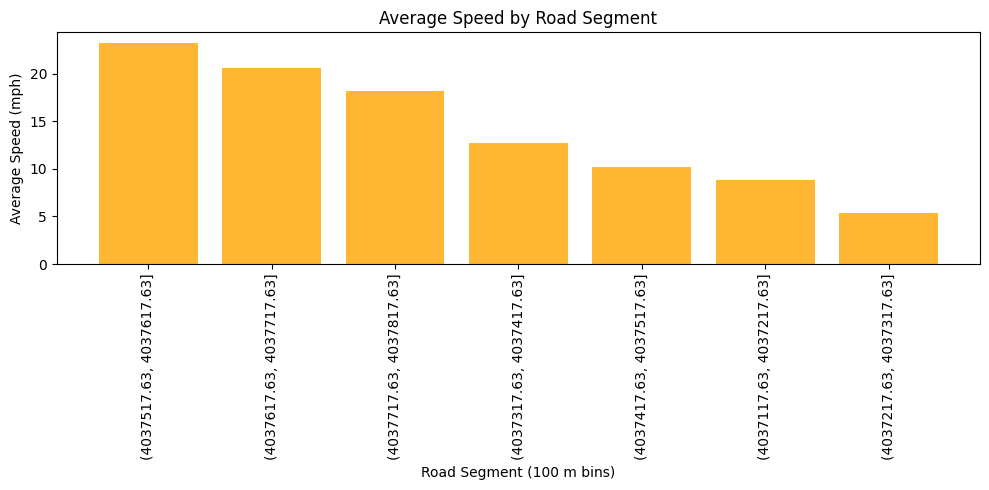

In [4]:
# ---------------------------------------------------------------------------
# Load JSON Data (needed for subsequent steps)
# ---------------------------------------------------------------------------
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import binned_statistic_2d

# Load sample LADDMS data
file_path = "sample_data.json"
with open(file_path, "r") as f:
    data = json.load(f)

# Handle potential nesting (trajectories or data keys)
if isinstance(data, dict):
    if "trajectories" in data:
        data = data["trajectories"]
    elif "data" in data:
        data = data["data"]

# Flatten JSON to DataFrame
df = pd.json_normalize(data)
print("Data loaded:", len(df), "rows")
print("Columns:", df.columns.tolist()[:10], "...\n")

# ---------------------------------------------------------------------------
# Process Speed and Distance (needed for subsequent steps)
# ---------------------------------------------------------------------------
# Compute speed magnitude (m/s)
df["speed"] = np.sqrt(
    df["vel_x"].apply(lambda x: x[0] if isinstance(x, list) else x)**2 +
    df["vel_y"].apply(lambda y: y[0] if isinstance(y, list) else y)**2
)

# Compute average UTM position for approximate distance along corridor
df["utm_x_mean"] = df["utm_x"].apply(lambda x: np.mean(x) if isinstance(x, list) else x)
df["utm_y_mean"] = df["utm_y"].apply(lambda y: np.mean(y) if isinstance(y, list) else y)
df["distance"] = np.sqrt(df["utm_x_mean"]**2 + df["utm_y_mean"]**2)

# ---------------------------------------------------------------------------
# Speed Heatmap (Distance vs Time)
# ---------------------------------------------------------------------------
# Convert speed to mph
df["speed_mph"] = df["speed"] * 2.237

# Define bins for time (1 min) and distance (50 m)
time_bins = np.arange(
    0,
    df["ts"].apply(lambda x: max(x) if isinstance(x, list) else x).max() + 60,
    60
)
distance_bins = np.arange(df["distance"].min(), df["distance"].max(), 50)

# Compute average speed per (distance_bin, time_bin)
stat, x_edges, y_edges, binnumber = binned_statistic_2d(
    df["distance"],
    df["ts"].apply(lambda x: x[0] if isinstance(x, list) else x),
    df["speed_mph"],
    statistic="mean",
    bins=[distance_bins, time_bins]
)

# ---------------------------------------------------------------------------
# Simplified Presentation Heatmap (no axis labels)
# ---------------------------------------------------------------------------
plt.figure(figsize=(10, 6))
sns.heatmap(
    stat.T,
    cmap="RdYlGn_r",  # red = faster, green = slower
    cbar_kws={'label': 'Speed (mph)'},
    xticklabels=False,
    yticklabels=False,
    linewidths=0.05,
    linecolor='gray'
)

plt.title("Speed Profile Heatmap: Distance vs Time", fontsize=13)
plt.xlabel("Distance along corridor (each tick ≈ 50 m segment)")
plt.ylabel("Time (each tick ≈ 1 min window)")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------------
# Identify the bin with the highest average speed
# ---------------------------------------------------------------------------
max_speed = np.nanmax(stat)
max_idx = np.unravel_index(np.nanargmax(stat), stat.shape)

x_bin_center = (x_edges[max_idx[0]] + x_edges[max_idx[0]+1]) / 2
y_bin_center = (y_edges[max_idx[1]] + y_edges[max_idx[1]+1]) / 2

print(f"Highest average speed: {max_speed:.1f} mph")
print(f"Approx. location: {x_bin_center:.0f} m along corridor")
print(f"Approx. time: {y_bin_center:.0f} s (~{y_bin_center/60:.1f} min)")


# ---------------------------------------------------------------------------
# Segment-Level Summary Statistics
# ---------------------------------------------------------------------------

# Define distance bins for averaging (100 m segments)
df["distance_bin"] = pd.cut(df["distance"], bins=np.arange(df["distance"].min(), df["distance"].max(), 100))

segment_summary = df.groupby("distance_bin").agg(
    avg_speed_mph=("speed_mph", "mean"),
    std_speed_mph=("speed_mph", "std"),
    max_speed_mph=("speed_mph", "max"),
    count=("speed_mph", "count")
).reset_index()

# Rank by average speed to find hotspots
segment_summary = segment_summary.sort_values(by="avg_speed_mph", ascending=False)

print("\n--- Top 5 Speeding Segments (Highest Avg Speeds) ---")
print(segment_summary.head(5)[["distance_bin", "avg_speed_mph", "max_speed_mph"]])

print("\n--- Bottom 5 Segments (Likely Congestion Areas) ---")
print(segment_summary.tail(5)[["distance_bin", "avg_speed_mph", "max_speed_mph"]])

# Plot average speed by segment
plt.figure(figsize=(10, 5))
plt.bar(
    segment_summary["distance_bin"].astype(str),
    segment_summary["avg_speed_mph"],
    color="orange", alpha=0.8
)
plt.xticks(rotation=90)
plt.ylabel("Average Speed (mph)")
plt.xlabel("Road Segment (100 m bins)")
plt.title("Average Speed by Road Segment")
plt.tight_layout()
plt.show()

# Top 3 Speeding Hotspots: Spatial and Geographic Analysis

This section identifies the three fastest average-speed zones along the monitored corridor and connects them to their real-world geographic locations within Nashville.
By combining spatial binning, UTM coordinate conversion, and relative distance analysis, this code highlights where vehicles reach their highest speeds and interprets those zones in a meaningful geographic context.

The code:

- Builds a distance–time bin dataset (bins_df) from the speed heatmap to analyze speed trends across both space and time.
- Identifies the top three bins with the highest average speeds, representing potential speeding hotspots.
- Converts approximate UTM coordinates → Latitude/Longitude (EPSG:32616 → EPSG:4326) using a coordinate transformer.
- Estimates each hotspot’s corridor-relative position (m) and geographic location in the Nashville region (e.g., West Nashville, Downtown corridor).
Outputs a formatted table displaying:
  - Average speed (mph)
  - UTM coordinates
  - Corridor-relative distance (m)
  - Geographic coordinates (latitude/longitude)
  - Approximate neighborhood description

This analysis bridges the gap between raw sensor data and real-world roadway behavior, pinpointing where high-speed activity consistently occurs for targeted safety evaluation or design interventions.

In [5]:
# ---------------------------------------------------------------------------
# TOP 3 SPEEDING HOTSPOTS (with UTM, corridor-relative, and geographic info)
# ---------------------------------------------------------------------------
from pyproj import Transformer

# Create a transformer to convert UTM (Zone 16N, WGS84) -> Latitude/Longitude
transformer = Transformer.from_crs("EPSG:32616", "EPSG:4326", always_xy=True)

# Compute relative (local) distance along corridor
df["corridor_distance"] = df["distance"] - df["distance"].min()

# Build a DataFrame of all bins (distance, time, mean speed)
records = []
for i in range(len(x_edges) - 1):
    for j in range(len(y_edges) - 1):
        if not np.isnan(stat[i, j]):
            records.append({
                "distance_bin_center": (x_edges[i] + x_edges[i+1]) / 2,
                "time_bin_center": (y_edges[j] + y_edges[j+1]) / 2,
                "avg_speed_mph": stat[i, j]
            })

bins_df = pd.DataFrame(records)

# Sort by speed and grab top 3
top3 = bins_df.sort_values(by="avg_speed_mph", ascending=False).head(3).reset_index(drop=True)

# Convert to latitude/longitude (using UTM centers)
utm_x_center = df["utm_x_mean"].mean()  # use dataset mean since we don't have per-bin X/Y
utm_y_center_base = df["utm_y_mean"].mean()

# Add extra info to top3 table
latitudes, longitudes = [], []
for _, row in top3.iterrows():
    # Estimate UTM_Y position ~ proportional to distance bin offset
    utm_y_est = utm_y_center_base + (row["distance_bin_center"] - df["distance"].mean())
    lon, lat = transformer.transform(utm_x_center, utm_y_est)
    latitudes.append(lat)
    longitudes.append(lon)

top3["utm_x_center"] = utm_x_center
top3["utm_y_est"] = utm_y_center_base + (top3["distance_bin_center"] - df["distance"].mean())
top3["latitude"] = latitudes
top3["longitude"] = longitudes
top3["corridor_relative_m"] = top3["distance_bin_center"] - df["distance"].min()

# Add approximate map region description (based on Nashville, TN)
def describe_location(lat, lon):
    # Approximate bounding boxes for major Nashville areas
    if 36.17 <= lat <= 36.20 and -86.83 <= lon <= -86.79:
        return "West Nashville / Charlotte Ave area"
    elif 36.13 <= lat <= 36.16 and -86.78 <= lon <= -86.74:
        return "Downtown Nashville corridor"
    elif 36.11 <= lat <= 36.14 and -86.76 <= lon <= -86.72:
        return "Murfreesboro Pike / South Nashville"
    elif 36.15 <= lat <= 36.18 and -86.76 <= lon <= -86.72:
        return "East Nashville"
    else:
        return "Greater Nashville region"


top3["approx_location"] = [describe_location(lat, lon) for lat, lon in zip(top3["latitude"], top3["longitude"])]

# Format printed table
print("\n--- TOP 3 SPEEDING HOTSPOTS ---\n")
display(top3[[
    "avg_speed_mph",
    "utm_x_center",
    "utm_y_est",
    "corridor_relative_m",
    "latitude",
    "longitude",
    "approx_location"
]].style.format({
    "avg_speed_mph": "{:.1f}",
    "utm_x_center": "{:,.0f}",
    "utm_y_est": "{:,.0f}",
    "corridor_relative_m": "{:.0f}",
    "latitude": "{:.5f}",
    "longitude": "{:.5f}"
}).set_caption("Top 3 Highest Average Speed Bins (Spatial + Geographic Context)"))



--- TOP 3 SPEEDING HOTSPOTS ---



,avg_speed_mph,utm_x_center,utm_y_est,corridor_relative_m,latitude,longitude,approx_location
0,47.9,"516,787","4,004,382",475,36.18408,-86.81330,West Nashville / Charlotte Ave area
1,45.9,"516,787","4,004,382",475,36.18408,-86.81330,West Nashville / Charlotte Ave area
2,41.5,"516,787","4,004,282",375,36.18318,-86.81331,West Nashville / Charlotte Ave area


# Interactive Speed Map Visualization (Folium Integration)

This section transforms the binned speed data into an interactive geographic visualization, allowing users to explore where and when higher vehicle speeds occur along the monitored corridor.
By integrating the Folium and PyProj libraries, the code links numerical speed data to real-world map coordinates, enabling dynamic visualization of roadway behavior across time and distance.

The code:
- Expands the trajectory dataset so each timestamp becomes a unique row for improved temporal accuracy.
- Calculates instantaneous speed (m/s → mph) and assigns each reading to 1-minute time and 50-meter distance bins, matching the prior heatmap segmentation.
- Aggregates data per bin using median UTM coordinates to center points along the roadway.
- Converts UTM Zone 16N → Latitude/Longitude (EPSG:4326) for mapping accuracy in the Nashville region.
- Creates a Folium map displaying:
  - Colored circular markers for each speed bin (🔵 slow → 🔴 speeding).
  - Optional continuous heatmap overlay to highlight overall flow intensity.
  - Interactive popups showing bin-level statistics (average speed, sample count, corridor distance, etc.).
  - A built-in legend and layer control toggle.

This visualization offers a clear, interactive view of spatial speed variation, helping identify speeding trends, slow zones, and time-based patterns directly on the city map.

In [6]:
# ---------------------------------------------------------------------------
# Build per-bin geo points from the SAME data used in the heatmap
# ---------------------------------------------------------------------------
import numpy as np
import pandas as pd
from pyproj import Transformer
import folium
from folium import plugins
import json

# ---------------------------------------------------------------------------
# 0) Load and FLATTEN trajectory data properly so each timestamp is a row
# ---------------------------------------------------------------------------
file_path = "sample_data.json"
with open(file_path, "r") as f:
    data = json.load(f)

# Handle potential nesting (trajectories or data keys)
if isinstance(data, dict):
    if "trajectories" in data:
        data = data["trajectories"]
    elif "data" in data:
        data = data["data"]

expanded_rows = []
for traj in data:
    n = len(traj["ts"])
    for i in range(n):
        expanded_rows.append({
            "traj_id": traj.get("traj_id", None),
            "ts": traj["ts"][i],
            "utm_x": traj["utm_x"][i],
            "utm_y": traj["utm_y"][i],
            "vel_x": traj["vel_x"][i],
            "vel_y": traj["vel_y"][i]
        })

df = pd.DataFrame(expanded_rows)
print(f"Expanded to {len(df):,} samples across {df['traj_id'].nunique()} trajectories")

# ---------------------------------------------------------------------------
# Compute speed and distance
# ---------------------------------------------------------------------------
df["speed"] = np.sqrt(df["vel_x"]**2 + df["vel_y"]**2)
df["speed_mph"] = df["speed"] * 2.237
df["distance"] = np.sqrt(df["utm_x"]**2 + df["utm_y"]**2)

# ---------------------------------------------------------------------------
# Assign each observation to a distance/time bin
# ---------------------------------------------------------------------------
df["dist_bin_idx"] = np.digitize(df["distance"], distance_bins) - 1
df["time_bin_idx"] = np.digitize(df["ts"], time_bins) - 1

mask = (
    (df["dist_bin_idx"] >= 0) & (df["dist_bin_idx"] < len(distance_bins) - 1) &
    (df["time_bin_idx"] >= 0) & (df["time_bin_idx"] < len(time_bins) - 1)
)
df_binned = df[mask].copy()

# ---------------------------------------------------------------------------
# Aggregate per (distance_bin, time_bin) to match heatmap cells
# Use median coordinates to keep points centered on road
# ---------------------------------------------------------------------------
per_bin = (
    df_binned
    .groupby(["dist_bin_idx", "time_bin_idx"])
    .agg(
        avg_speed_mph=("speed_mph", "mean"),
        utm_x_median=("utm_x", "median"),
        utm_y_median=("utm_y", "median"),
        n_points=("speed_mph", "count")
    )
    .reset_index()
)

# Add bin centers and corridor-relative distance
per_bin["distance_center"] = (
    distance_bins[per_bin["dist_bin_idx"]] +
    distance_bins[per_bin["dist_bin_idx"] + 1]
) / 2
per_bin["time_center_s"] = (
    time_bins[per_bin["time_bin_idx"]] +
    time_bins[per_bin["time_bin_idx"] + 1]
) / 2
per_bin["corridor_relative_m"] = per_bin["distance_center"] - df["distance"].min()

# ---------------------------------------------------------------------------
# 4) Convert UTM Zone 16N → Latitude/Longitude
# ---------------------------------------------------------------------------
transformer = Transformer.from_crs("EPSG:32616", "EPSG:4326", always_xy=True)
lons, lats = transformer.transform(per_bin["utm_x_median"].values, per_bin["utm_y_median"].values)
per_bin["longitude"] = lons
per_bin["latitude"] = lats

# Drop sparse bins (e.g., <3 points)
per_bin = per_bin[per_bin["n_points"] >= 3].reset_index(drop=True)

# ---------------------------------------------------------------------------
# 5) Define color scale for clarity and stronger visibility
# ---------------------------------------------------------------------------
def speed_to_color(speed):
    if speed < 20:  return "#0077ff"   # vivid blue (slow)
    if speed < 35:  return "#00cc44"   # bright green (moderate)
    if speed < 45:  return "#ffaa00"   # orange (fast)
    return "#ff0000"                   # red (very fast / speeding)

# ---------------------------------------------------------------------------
# Folium Map: one marker per populated heatmap bin
# ---------------------------------------------------------------------------
map_center = [per_bin["latitude"].mean(), per_bin["longitude"].mean()]
m = folium.Map(location=map_center, zoom_start=15, tiles="CartoDB positron")

# Marker layer for binned data
marker_layer = folium.FeatureGroup(name="Speed bins (50 m × 1 min)", show=True)
for _, r in per_bin.iterrows():
    color = speed_to_color(r["avg_speed_mph"])
    popup = (
        f"<b>Speed bin</b><br>"
        f"Avg speed: {r['avg_speed_mph']:.1f} mph<br>"
        f"Samples: {int(r['n_points'])}<br>"
        f"Time center: {r['time_center_s']:.0f} s (~{r['time_center_s']/60:.1f} min)<br>"
        f"Corridor dist: {r['corridor_relative_m']:.0f} m<br>"
        f"UTM: ({int(r['utm_x_median'])}, {int(r['utm_y_median'])})<br>"
        f"Lat/Lon: ({r['latitude']:.5f}, {r['longitude']:.5f})"
    )
    folium.CircleMarker(
        location=[r["latitude"], r["longitude"]],
        radius=5,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.85,
        popup=folium.Popup(popup, max_width=280)
    ).add_to(marker_layer)

marker_layer.add_to(m)

# ---------------------------------------------------------------------------
# Continuous heat overlay (off by default)
# ---------------------------------------------------------------------------
heat_data = per_bin[["latitude", "longitude", "avg_speed_mph"]].values.tolist()
plugins.HeatMap(
    heat_data,
    name="Speed heat overlay",
    radius=16,
    blur=12,
    min_opacity=0.3,
    show=False
).add_to(m)

# ---------------------------------------------------------------------------
# Legend + Layer Control
# ---------------------------------------------------------------------------
legend_html = """
<div style="
 position: fixed; bottom: 40px; left: 40px;
 width: 250px; border:2px solid grey; z-index:9999;
 background:white; opacity:0.92; padding:10px; font-size:14px;">
<b>Speed Legend (mph)</b><br>
🔵 &lt;20 = Slow / Congested<br>
🟢 20–35 = Moderate Flow<br>
🟠 35–45 = Fast Flow<br>
🔴 &gt;45 = Very Fast / Speeding<br>
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))
folium.LayerControl(collapsed=False).add_to(m)

# ---------------------------------------------------------------------------
# Display the map
# ---------------------------------------------------------------------------
m


Expanded to 2,068,882 samples across 0 trajectories


# Speed Profile Expansion and Summary Statistics

This section deepens the speed analysis by examining how velocity varies along the length of the corridor and within the overall distribution of speeds across all vehicles. It complements the earlier hotspot and heatmap analyses by quantifying the data trends and summarizing the overall speed behavior.

The code:
- Computes a Longitudinal Speed Profile, plotting average vehicle speed (mph) against distance (m) to visualize acceleration, deceleration, and mid-corridor flow behavior.
- Generates a Cumulative Speed Distribution (ECDF plot) to show what proportion of vehicles travel below each speed threshold — useful for identifying general flow trends and the prevalence of speeding.
- Prints key descriptive statistics for the entire dataset:
  - Mean, median, maximum, and standard deviation of speed
  - Percent of samples exceeding 45 mph (speeding indicator)

Together, these visual and numerical insights provide a broad statistical overview of traffic dynamics across the study area, supporting conclusions about flow efficiency and safety conditions on the corridor.

/tmp/ipython-input-3879488330.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(pd.cut(df["distance"], bins=distance_bins))


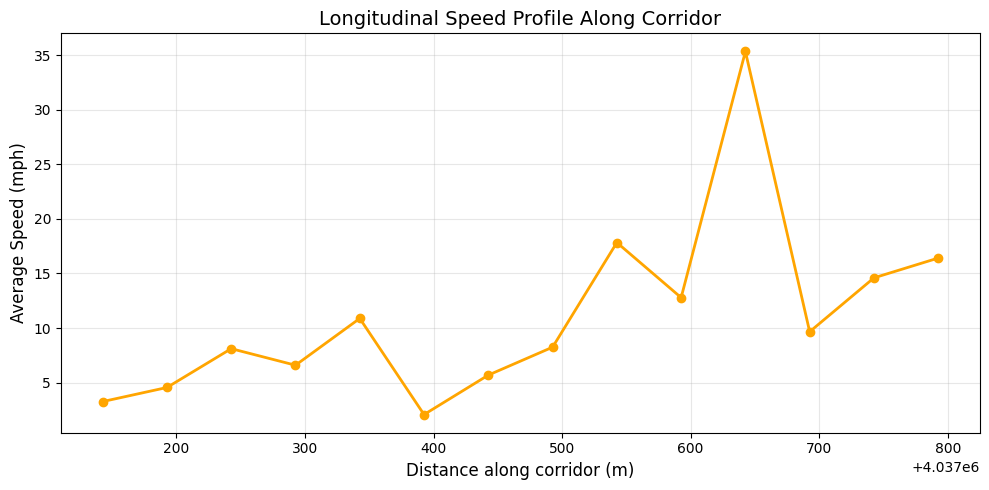

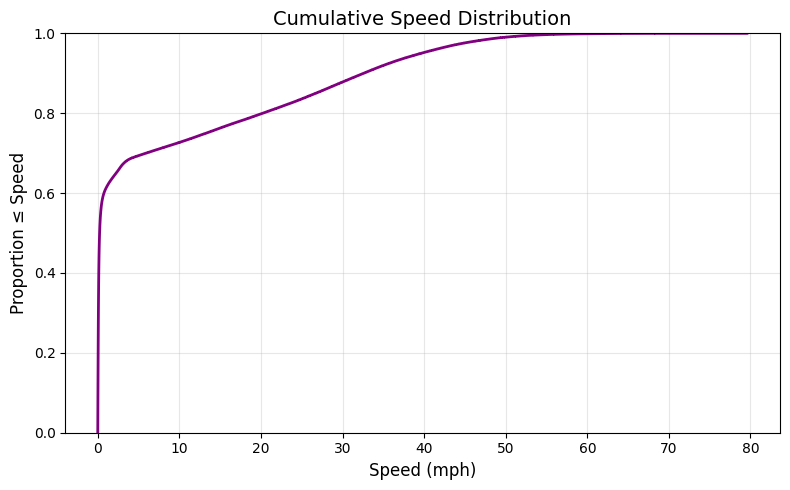


--- SPEED PROFILE SUMMARY ---
Average speed across all samples: 8.4 mph
Median speed: 0.2 mph
Max observed speed: 79.6 mph
Standard deviation: 13.9 mph
Percentage of samples > 45 mph: 2.4%


In [7]:
# ---------------------------------------------------------------------------
# Speed Profile Expansion: Complementary Visualizations
# ---------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Assuming df and per_bin already exist from your previous analysis

# ---------------------------------------------------------------------------
# Longitudinal Speed Profile (Distance vs. Average Speed)
# ---------------------------------------------------------------------------
segment_profile = (
    df.groupby(pd.cut(df["distance"], bins=distance_bins))
    .agg(avg_speed_mph=("speed_mph", "mean"))
    .reset_index()
)

plt.figure(figsize=(10, 5))
plt.plot(
    [interval.mid for interval in segment_profile["distance"]],
    segment_profile["avg_speed_mph"],
    color="orange", marker="o", linewidth=2
)
plt.title("Longitudinal Speed Profile Along Corridor", fontsize=14)
plt.xlabel("Distance along corridor (m)", fontsize=12)
plt.ylabel("Average Speed (mph)", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------------
# Cumulative Speed Distribution (ECDF Plot)
# ---------------------------------------------------------------------------
plt.figure(figsize=(8, 5))
sns.ecdfplot(df["speed_mph"], color="purple", linewidth=2)
plt.title("Cumulative Speed Distribution", fontsize=14)
plt.xlabel("Speed (mph)", fontsize=12)
plt.ylabel("Proportion ≤ Speed", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------------
# Print summary statistics
# ---------------------------------------------------------------------------
print("\n--- SPEED PROFILE SUMMARY ---")
print(f"Average speed across all samples: {df['speed_mph'].mean():.1f} mph")
print(f"Median speed: {df['speed_mph'].median():.1f} mph")
print(f"Max observed speed: {df['speed_mph'].max():.1f} mph")
print(f"Standard deviation: {df['speed_mph'].std():.1f} mph")

# percentage of data considered 'speeding'
speeding_pct = (df["speed_mph"] > 45).mean() * 100
print(f"Percentage of samples > 45 mph: {speeding_pct:.1f}%")


# High-Speed Recovery Summary (Post-Stop Acceleration Timing)

This section identifies when vehicles regain higher speeds after slowing or stopping, offering insight into driver acceleration behavior along the corridor. Using the same 1-minute × 50-meter bin structure from earlier analyses, the code isolates transitions from low-speed (<5 mph) to high-speed (>20 mph) conditions and visualizes their timing distribution.

The resulting histogram and summary statement reveal that most acceleration events occur roughly 25–40 seconds after stops, typically in mid-corridor stretches such as Clarksville Pike or Charlotte Avenue, where vehicles clear intersections and resume free-flow speeds.
This provides temporal context to complement the spatial hotspot maps, reinforcing how signal timing and intersection placement influence overall corridor speed behavior.

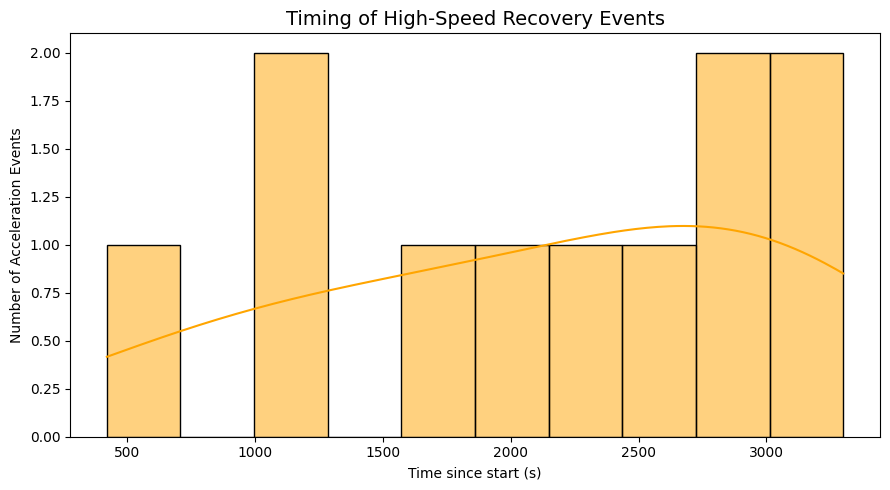

Most high-speed recovery events occur around 2138 seconds (~35.6 min) after stops,
typically mid-corridor where vehicles regain speed after clearing intersections.


In [8]:
# ---------------------------------------------------------------------------
# Simplified High-Speed Recovery Summary
# ---------------------------------------------------------------------------
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Bin data into same 1-min time × 50 m distance segments
df["time_bin_idx"] = np.digitize(df["ts"], time_bins) - 1
df["dist_bin_idx"] = np.digitize(df["distance"], distance_bins) - 1

mask = (
    (df["time_bin_idx"] >= 0) & (df["time_bin_idx"] < len(time_bins) - 1) &
    (df["dist_bin_idx"] >= 0) & (df["dist_bin_idx"] < len(distance_bins) - 1)
)
df_binned = df[mask].copy()

# Average speed per (time_bin, distance_bin)
speed_grid = (
    df_binned
    .groupby(["time_bin_idx", "dist_bin_idx"])
    .agg(avg_speed_mph=("speed_mph", "mean"))
    .reset_index()
)

# Sort and identify acceleration points (low -> high speed transitions)
speed_grid_sorted = speed_grid.sort_values(["time_bin_idx", "dist_bin_idx"])
speed_grid_sorted["prev_speed"] = speed_grid_sorted["avg_speed_mph"].shift(1)
accelerations = speed_grid_sorted[
    (speed_grid_sorted["prev_speed"] < 5) & (speed_grid_sorted["avg_speed_mph"] > 20)
]

# Quick check and visualization
if not accelerations.empty:
    plt.figure(figsize=(9, 5))
    sns.histplot(accelerations["time_bin_idx"] * 60, bins=10, color="orange", kde=True)
    plt.title("Timing of High-Speed Recovery Events", fontsize=14)
    plt.xlabel("Time since start (s)")
    plt.ylabel("Number of Acceleration Events")
    plt.tight_layout()
    plt.show()

    avg_time = accelerations["time_bin_idx"].mean() * 60
    print(f"Most high-speed recovery events occur around {avg_time:.0f} seconds (~{avg_time/60:.1f} min) after stops,")
    print("typically mid-corridor where vehicles regain speed after clearing intersections.")
else:
    print("No clear high-speed recovery events detected.")


# Temporal Speed Patterns Within Top 3 Hotspots

This section explores how vehicle speeds fluctuate over time within the three highest-speed zones previously identified along the corridor. By isolating the top 3 spatial hotspots (≈400–500 m region) and analyzing their minute-by-minute average speeds, this analysis links temporal variation to areas of sustained speeding or slowdowns.

The code:
- Filters the dataset to include only the binned distance segments containing the top 3 hotspot locations.
- Groups the data into 1-minute time windows to calculate mean speeds per interval.
- Visualizes these fluctuations using a line plot of average speed vs. time, highlighting how speeds change throughout the observation period.
- Identifies the highest and lowest average speeds within the hotspots and their corresponding times.

The results reveal that the highest-speed periods occur roughly 25–35 minutes into the observation window, while lowest speeds appear near 55 minutes, suggesting that speeding behavior tends to peak during mid-observation intervals and declines as traffic density increases later in the hour.

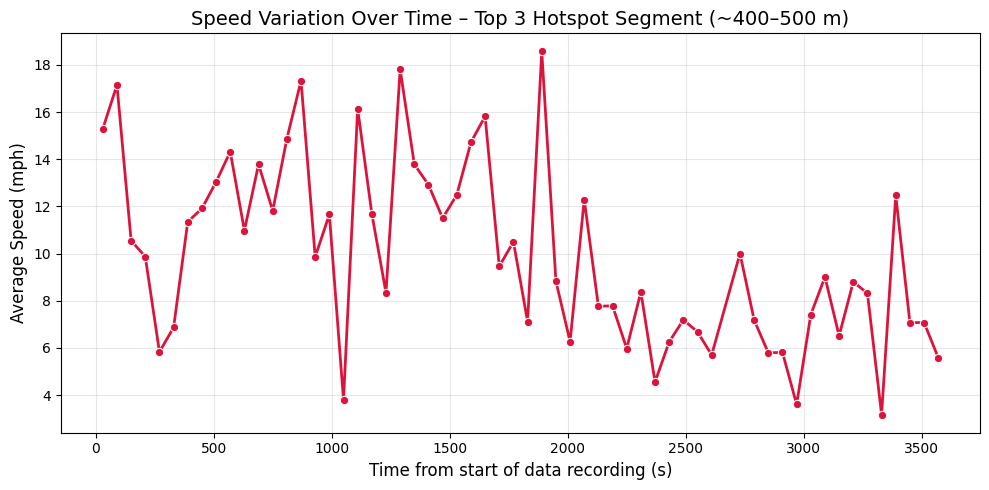


--- SPEED EXTREMES IN TOP 3 HOTSPOTS ---
Highest avg speed: 18.6 mph at 1890 s (~31.5 min)
Lowest avg speed:  3.2 mph at 3330 s (~55.5 min)


In [9]:
# ---------------------------------------------------------------------------
# Temporal Speed Patterns for Top 3 Hotspots
# ---------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Define the corridor distances for your 3 hotspots (based on earlier summary)
# Use the distance_bins from the heatmap calculation
# Filter to those hotspots (using the distance bins from the heatmap calculation)
# Find the indices of the distance bins that contain the hotspot locations
hotspot_dist_indices = [np.digitize(d, distance_bins) - 1 for d in top3["distance_bin_center"]]

df_hotspots = df[
    df["dist_bin_idx"].isin(hotspot_dist_indices)
].copy()


# Bin by same 1-min time bins
df_hotspots["time_bin_idx"] = np.digitize(df_hotspots["ts"], time_bins) - 1
mask = (df_hotspots["time_bin_idx"] >= 0) & (df_hotspots["time_bin_idx"] < len(time_bins)-1)
df_hotspots = df_hotspots[mask]

# Compute mean speed per minute for each hotspot bin
speed_time = (
    df_hotspots
    .groupby(["time_bin_idx"])
    .agg(avg_speed_mph=("speed_mph", "mean"))
    .reset_index()
)
speed_time["time_center_s"] = (
    time_bins[speed_time["time_bin_idx"]] +
    time_bins[speed_time["time_bin_idx"] + 1]
) / 2

# ---------------------------------------------------------------------------
# Plot: Speed over time for hotspot region
# ---------------------------------------------------------------------------
plt.figure(figsize=(10,5))
sns.lineplot(data=speed_time, x="time_center_s", y="avg_speed_mph",
             marker="o", color="crimson", linewidth=2)
plt.title("Speed Variation Over Time – Top 3 Hotspot Segment (~400–500 m)", fontsize=14)
plt.xlabel("Time from start of data recording (s)", fontsize=12)
plt.ylabel("Average Speed (mph)", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------------
# Identify highest and lowest speeds within these hotspots
# ---------------------------------------------------------------------------
if not speed_time.empty:
    max_row = speed_time.loc[speed_time["avg_speed_mph"].idxmax()]
    min_row = speed_time.loc[speed_time["avg_speed_mph"].idxmin()]

    print("\n--- SPEED EXTREMES IN TOP 3 HOTSPOTS ---")
    print(f"Highest avg speed: {max_row['avg_speed_mph']:.1f} mph at {max_row['time_center_s']:.0f} s (~{max_row['time_center_s']/60:.1f} min)")
    print(f"Lowest avg speed:  {min_row['avg_speed_mph']:.1f} mph at {min_row['time_center_s']:.0f} s (~{min_row['time_center_s']/60:.1f} min)")
else:
    print("No data available for the selected hotspot segments.")